# Import and Download

In [1]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5

--2022-07-14 13:28:14--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.192.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289777 (283K) [application/json]
Saving to: ‘TEST_CAPTIONS_coco_5_cap_per_img.json.3’

TEST_CAPTIONS_coco_ 100%[===================>] 282.99K  --.-KB/s    in 0.002s  

2022-07-14 13:28:14 (116 MB/s) - ‘TEST_CAPTIONS_coco_5_cap_per_img.json.3’ saved [289777/289777]

--2022-07-14 13:28:14--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 108.177.120.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.128|:443... connected.
HTT

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install resize_right

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import torch
from transformers import T5Tokenizer, T5EncoderModel, T5Config

import transformers

from torchvision import transforms
import torchvision.transforms as T

from torch.utils.data import Dataset, DataLoader

import torch
from torch.utils.data import Dataset

import numpy as np

import json, h5py, random
from resize_right import resize

# TextEncoder

In [6]:
class TextEncoderT5Based():
    
    def __init__(self, name = 'google/t5-v1_1-small', device='cpu'):
        
        self.device    = device
        self.model     = T5EncoderModel.from_pretrained(name).to(device)
        self.tokenizer = T5Tokenizer.from_pretrained(name)
        self.embed_dim = T5Config.from_pretrained(name).d_model
        
    def textEncoder(self, texts, max_length=256):
        
        text_encoded = self.tokenizer.batch_encode_plus(texts, return_tensors = "pt", padding = 'longest',
                                                        max_length = max_length, truncation = True)
        
        text_ids = text_encoded.input_ids.to(self.device)
        mask     = text_encoded.attention_mask.to(self.device)
        
        self.model.eval()
        
        with torch.no_grad(): encoded_text = self.model(text_ids, mask).last_hidden_state.detach()
                
        return encoded_text, mask.bool()        

In [7]:
T5 = TextEncoderT5Based()
print(T5.textEncoder(['I', 'you', 'yes my'])[0].shape)
print()
print(T5.textEncoder(['I', 'yes'])[0].shape)
print()
print(T5.textEncoder(['I', 'you', 'yes my'])[0])
print()
print(T5.textEncoder(['I', 'you', 'yes my'])[1])
print('\nDimension:', T5.embed_dim)

Some weights of the model checkpoint at google/t5-v1_1-small were not used when initializing T5EncoderModel: ['decoder.block.6.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.6.layer.0.SelfAttention.q.weight', 'decoder.block.1.layer.1.layer_norm.weight', 'decoder.block.5.layer.2.DenseReluDense.wi_1.weight', 'lm_head.weight', 'decoder.block.2.layer.0.layer_norm.weight', 'decoder.block.5.layer.0.SelfAttention.k.weight', 'decoder.block.4.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.3.layer.2.layer_norm.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.final_layer_norm.weight', 'decoder.block.4.layer.0.SelfAttention.v.weight', 'decoder.block.6.layer.0.SelfAttention.o.weight', 'decoder.block.2.layer.1.EncDecAttention.k.weight', 'decoder.block.4.layer.0.SelfAttention.k.weight', 'decoder.block.6.layer.1.EncDecAttenti

torch.Size([3, 3, 512])

torch.Size([2, 2, 512])

tensor([[[ 7.7179e-02, -9.5070e-03,  4.9422e-04,  ..., -1.7528e-01,
          -2.7931e-03,  7.0717e-01],
         [-3.6950e-01,  8.6837e-02, -1.3701e-01,  ..., -3.6052e-01,
          -1.9034e-01,  8.7761e-02],
         [ 8.3804e-02, -2.0349e-02,  5.8009e-03,  ..., -1.3579e-01,
          -1.9433e-02,  5.5632e-01]],

        [[ 7.4668e-02, -2.6701e-02, -3.7859e-03,  ..., -1.2131e-01,
          -2.6960e-02,  5.9868e-01],
         [-3.0119e-01, -4.8806e-01,  2.6033e-01,  ...,  1.0381e-01,
          -7.0362e-01,  9.3447e-01],
         [ 2.4204e-03, -1.6723e-01,  1.2286e-01,  ..., -3.0876e-01,
          -6.1628e-01,  6.4991e-01]],

        [[ 8.1621e-02, -2.6020e-02, -4.7645e-03,  ..., -1.2855e-01,
          -2.7603e-02,  6.2340e-01],
         [ 4.4333e-01,  2.6897e-01, -2.7354e-01,  ..., -3.6821e-01,
          -9.6742e-02, -1.9053e-01],
         [-1.2980e-01, -4.0838e-01,  1.0294e-01,  ..., -1.4140e-01,
          -4.8038e-01, -3.9026e-01]]])

# DATASET

In [103]:
from matplotlib import image
from resize_right import resize 
class CustomDataset(Dataset):
    def __init__(self, img_file, target_file, image_size=128):

        self.img_file = img_file
        self.captions = json.load(open(target_file, "r"))

        self.images   = None

        self.img_transform  = transforms.Compose([transforms.Resize(image_size),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.CenterCrop(image_size)])

    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
    
        if not self.images: self.images = h5py.File(self.img_file, 'r') 
            
        img = self.images["images"][idx].astype(float)
        img = torch.from_numpy((img - img.min()) / np.max([img.max() - img.min(), 1]))

        cap = self.captions[idx]       
                
        return self.img_transform(img), cap

    def __del__(self):
        if self.images:
            self.images.close()

def collate_any(batch):
   
    imgs  = torch.stack([r[0] for r in batch])
    texts = np.array([random.choice(r[1]) for r in batch])

    return imgs, texts

In [104]:
train_set = CustomDataset("./TRAIN_IMAGES_coco_5_cap_per_img.hdf5", "./TRAIN_CAPTIONS_coco_5_cap_per_img.json")
val_set   = CustomDataset("./VAL_IMAGES_coco_5_cap_per_img.hdf5",   "./VAL_CAPTIONS_coco_5_cap_per_img.json")
test_set  = CustomDataset("./TEST_IMAGES_coco_5_cap_per_img.hdf5",  "./TEST_CAPTIONS_coco_5_cap_per_img.json")

In [105]:
train_loader = DataLoader(train_set, batch_size=10, collate_fn=collate_any)

In [106]:
imgs, texts = next(iter(train_loader))

print(type(imgs), type(texts))

<class 'torch.Tensor'> <class 'numpy.ndarray'>


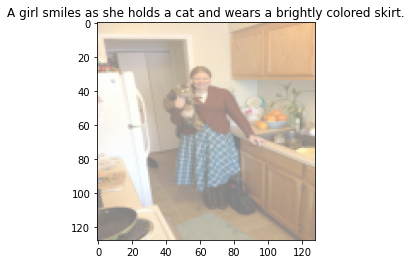

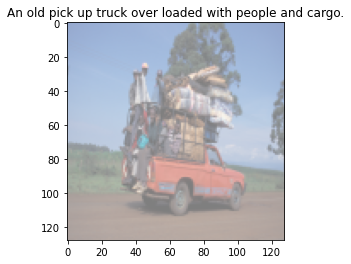

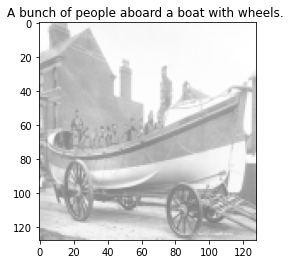

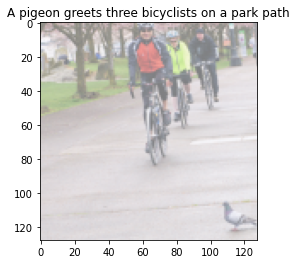

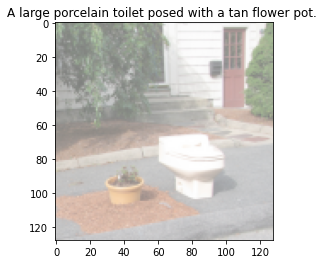

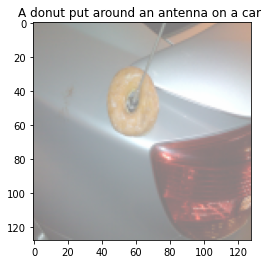

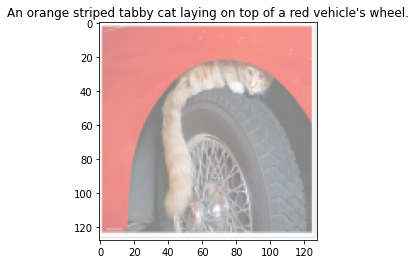

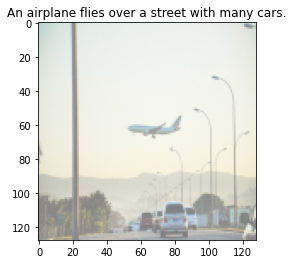

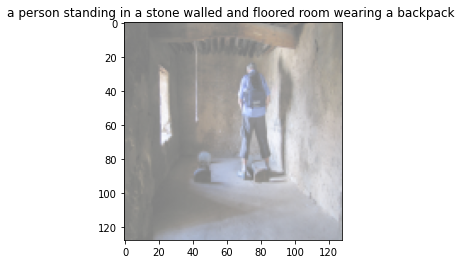

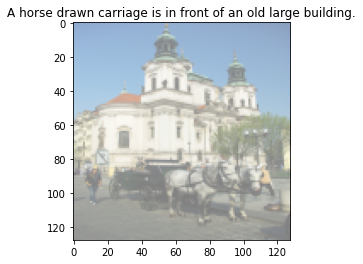

In [107]:
import matplotlib.pyplot as plt

imgs, texts = next(iter(train_loader))
for img, text in zip(imgs, texts):
    # Para apresentar as imagens é necessario desfazer a normalização empregada nas imagens
    plt.imshow((img.numpy().transpose(1, 2, 0)+1)/2) # adversarial
    plt.title(text)
    plt.show()

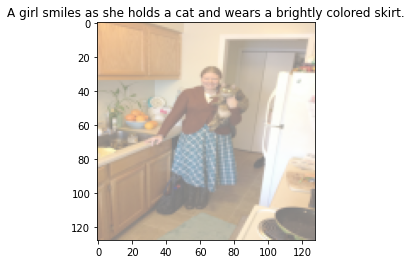

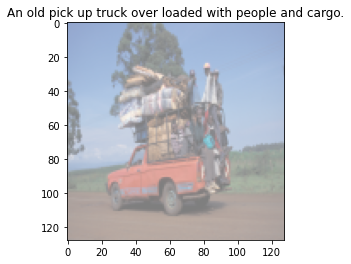

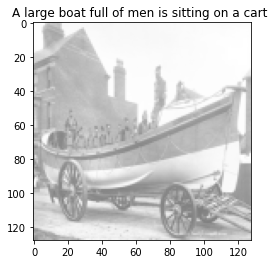

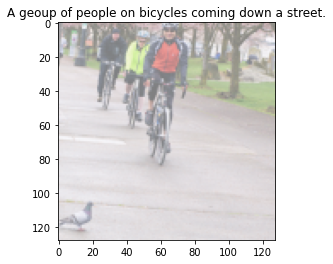

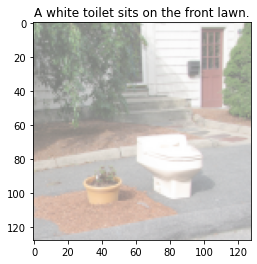

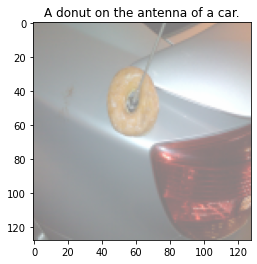

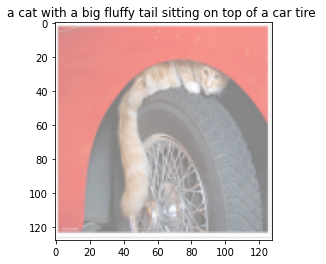

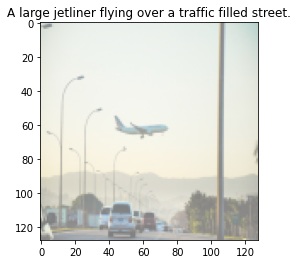

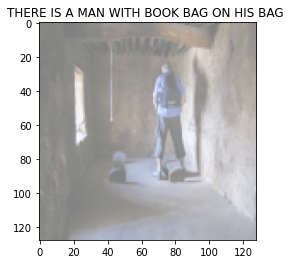

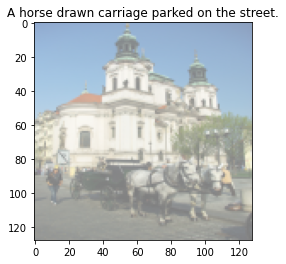

In [97]:
import matplotlib.pyplot as plt

imgs, texts = next(iter(train_loader))
for img, text in zip(imgs, texts):
    # Para apresentar as imagens é necessario desfazer a normalização empregada nas imagens
    plt.imshow((img.numpy().transpose(1, 2, 0)+1)/2) # adversarial
    plt.title(text)
    plt.show()

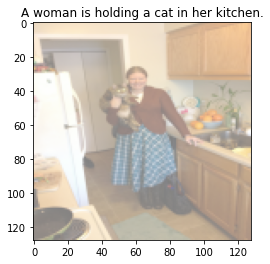

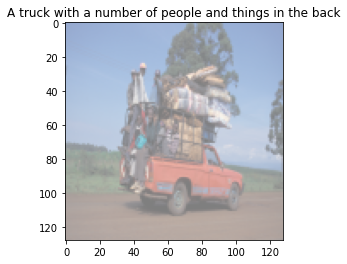

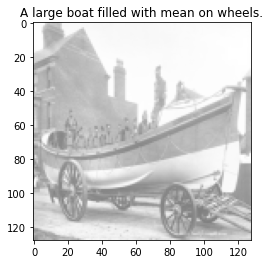

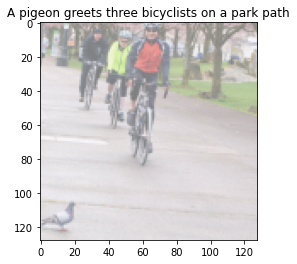

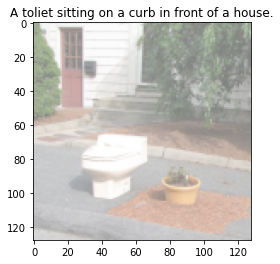

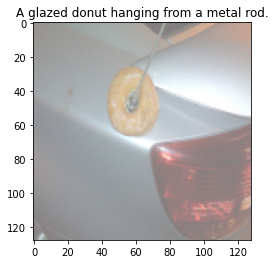

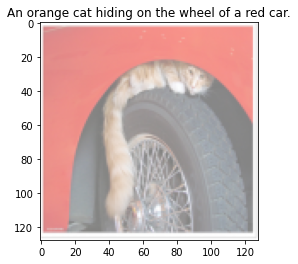

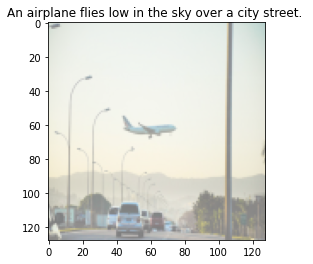

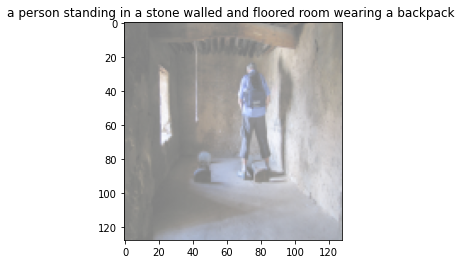

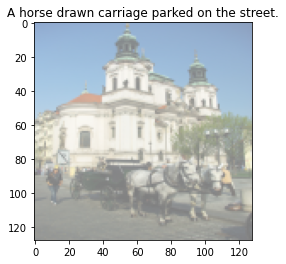

In [92]:
import matplotlib.pyplot as plt

imgs, texts = next(iter(train_loader))
for img, text in zip(imgs, texts):
    # Para apresentar as imagens é necessario desfazer a normalização empregada nas imagens
    plt.imshow((img.numpy().transpose(1, 2, 0)+1)/2) # adversarial
    plt.title(text)
    plt.show()

In [12]:
type(train_set.captions)

list

In [13]:
len(train_set.captions)

23520

In [25]:
train_set.captions[0]

['A woman in a room with a cat.',
 'a woman is holding a cat in her kitchen',
 'A woman is holding a cat in her kitchen.',
 'A girl smiles as she holds a cat and wears a brightly colored skirt.',
 'A woman is working in a kitchen carrying a soft toy.']

In [26]:
text_encoder = TextEncoderT5Based('google/t5-v1_1-small') 

Some weights of the model checkpoint at google/t5-v1_1-small were not used when initializing T5EncoderModel: ['decoder.block.2.layer.0.SelfAttention.v.weight', 'decoder.block.7.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.4.layer.1.layer_norm.weight', 'decoder.block.5.layer.1.EncDecAttention.o.weight', 'decoder.block.7.layer.0.layer_norm.weight', 'decoder.block.7.layer.2.DenseReluDense.wi_0.weight', 'decoder.block.0.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.6.layer.1.EncDecAttention.q.weight', 'decoder.block.1.layer.1.EncDecAttention.k.weight', 'decoder.block.6.layer.2.DenseReluDense.wi_1.weight', 'decoder.block.3.layer.0.SelfAttention.o.weight', 'decoder.block.7.layer.0.SelfAttention.o.weight', 'decoder.block.7.layer.1.EncDecAttention.k.weight', 'decoder.block.6.layer.2.DenseReluDense.wo.weight', 'decoder.block.2.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.1.EncDecAttention.v.weight', 'decoder.block.3.layer.0.S

In [27]:
text_embeds, text_masks = text_encoder.textEncoder(train_set.captions[0])

In [28]:
text_embeds.shape

torch.Size([5, 21, 512])

In [31]:
text_embeds = [text_encoder.textEncoder(train_set.captions[0]) for i in range(23520)]

KeyboardInterrupt: ignored

In [32]:
from tqdm.notebook import tqdm

In [38]:
texts = []
for i in tqdm(range(23520)):
    texts += train_set.captions[0]

  0%|          | 0/23520 [00:00<?, ?it/s]

In [ ]:
text_embeds, text_masks = text_encoder.textEncoder(texts)

In [37]:
train_set.captions[0] + train_set.captions[1]

['A woman in a room with a cat.',
 'a woman is holding a cat in her kitchen',
 'A woman is holding a cat in her kitchen.',
 'A girl smiles as she holds a cat and wears a brightly colored skirt.',
 'A woman is working in a kitchen carrying a soft toy.',
 'A group of people riding on the back of a loaded red pickup truck.',
 'A truck carries a large amount of items and a few people.',
 'A truck with a number of people and things in the back',
 'Men are crowded on the back of a small overloaded pickup truck.',
 'An old pick up truck over loaded with people and cargo.']

In [35]:
train_set.captions[0]

['A woman in a room with a cat.',
 'a woman is holding a cat in her kitchen',
 'A woman is holding a cat in her kitchen.',
 'A girl smiles as she holds a cat and wears a brightly colored skirt.',
 'A woman is working in a kitchen carrying a soft toy.']

In [36]:
train_set.captions[1]

['A group of people riding on the back of a loaded red pickup truck.',
 'A truck carries a large amount of items and a few people.',
 'A truck with a number of people and things in the back',
 'Men are crowded on the back of a small overloaded pickup truck.',
 'An old pick up truck over loaded with people and cargo.']

In [109]:
!pip install --pre pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 5.0 MB/s 


In [110]:
from ignite.metrics import FID

In [113]:
imgs[0].shape

torch.Size([3, 128, 128])

In [ ]:
metric = FID(num_features=1, feature_extractor=default_model)
metric.attach(default_evaluator, "fid")
y_true = torch.ones(10, 4)
y_pred = torch.ones(10, 4)
state = default_evaluator.run([[y_pred, y_true]])
print(state.metrics["fid"])

In [115]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

def FID(image, target_image):
    
    # Based on: https://arxiv.org/pdf/1706.08500.pdf
    # FID = ||Mr - Mg||^2 + Trace(COVr + COVg + 2*(COVr*COVg)**(1/2))
    
    if not isinstance(image, numpy.ndarray) or not isinstance(target_image, numpy.ndarray):
        image        = np.asarray(image)
        target_image = np.asarray(target_image)
        
    Mg, COVg = image.mean(axis=0),        cov(image, rowvar=False)
    Mr, COVr = target_image.mean(axis=0), cov(target_image, rowvar=False)
    
    covmean = sqrtm(COVg.dot(COVr))    
    
    if iscomplexobj(covmean):
        covmean = covmean.real

    fid = numpy.sum((Mr - Mg)**2.0) + trace(COVr + COVg - 2.0 * covmean **(0.5))

    return fid

In [117]:
FID(imgs[0], imgs[0])

ValueError: ignored

In [125]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
 
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
print('Pre', images1.shape, images2.shape)
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
Pre (10, 299, 299, 3) (10, 299, 299, 3)
FID (same): -0.000
FID (different): 37.927


In [151]:
 c = imgs[0]*255

In [165]:
a = torch.stack([c, c, c, c, c,
                 c, c, c, c, c])

In [179]:
a = torch.stack([imgs[0]*255, imgs[0]*255, imgs[0]*255, imgs[0]*255, imgs[0]*255,
                 imgs[0]*255, imgs[0]*255, imgs[0]*255, imgs[0]*255, imgs[0]*255])

In [174]:
d = torch.stack([imgs[1]*255, imgs[1]*255, imgs[1]*255, imgs[1]*255, imgs[1]*255,
                 imgs[1]*255, imgs[1]*255, imgs[1]*255, imgs[1]*255, imgs[1]*255])

In [166]:
c.min()

tensor(2.7827, dtype=torch.float64)

In [141]:
c = c.to(torch.long)

In [180]:
a = a.permute(0, 2, 3, 1)
d = d.permute(0, 2, 3, 1)

In [181]:
b = a.numpy()
e = d.numpy()

In [148]:
model = InceptionV3(include_top=False, pooling='avg', input_shape=(128, 128, 3))

In [182]:
calculate_fid(model, b, b)

0.0

In [177]:
calculate_fid(model, b, e)

InvalidArgumentError: ignored